# 区域区分

## shapeファイルの表示

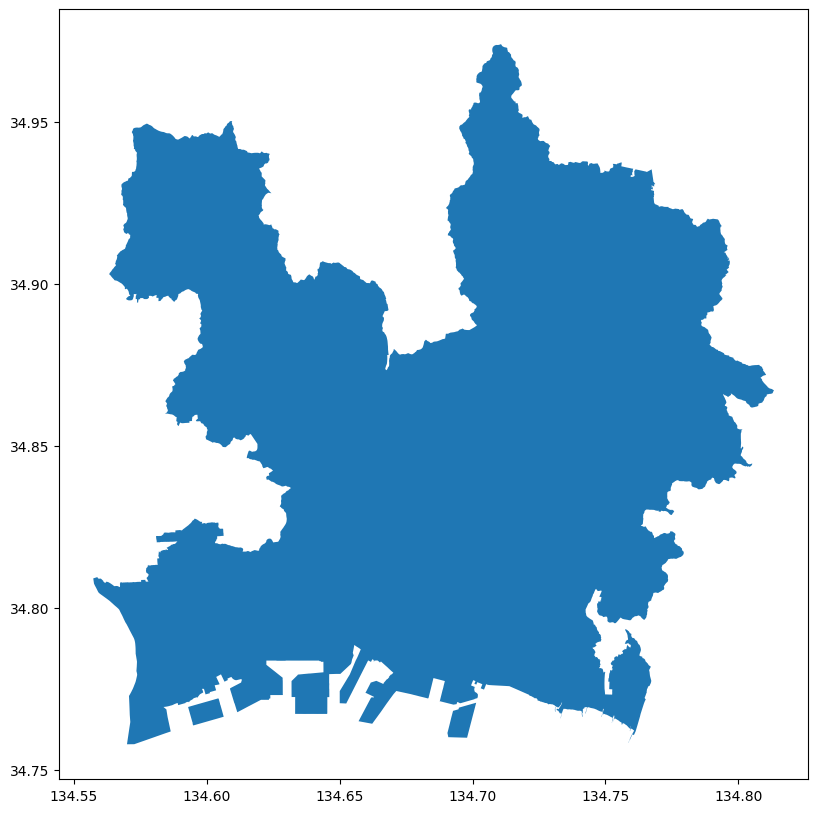

,tokeiname,Type,kubunID,Pref,Citycode,Cityname,当初決定日,最終告示日,決定区分,決定者,告示番号S,告示番号L
0,中播都市計画区域,都市計画区域,21,兵庫県,28201,姫路市,NaN,昭和46年3月16日,None,None,NaN,兵庫県告示第361号の3
1,中播都市計画区域,都市計画区域,21,兵庫県,28201,姫路市,NaN,昭和46年3月16日,None,None,NaN,兵庫県告示第361号の3
2,中播都市計画区域,都市計画区域,21,兵庫県,28201,姫路市,NaN,昭和46年3月16日,None,None,NaN,兵庫県告示第361号の3


In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# shapeファイルのパスを指定
shapefile_path = '../shape_org/28_兵庫県/28201_姫路市/28201_tokei.shp'

# GeoDataFrameを表示
gdf = gpd.read_file(shapefile_path)
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax)
plt.show()

# 属性情報をDataFrameとして取得
attr_df = pd.DataFrame(gdf.drop(columns='geometry'))
display(attr_df)



## shapeファイルの結合

「28_兵庫県」ディレクトリ内にある'_tokei.shp'ファイルのリストを作成する。

In [2]:
import os
import pprint 
from typing import List

def find_shp_files(root_dir: str, keyword: str ) -> List[str]:
 
    file_list = []
    for root, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.shp') and keyword in file:
                file_list.append(os.path.join(root, file))
    return file_list


root_directory = '../shape_org/28_兵庫県'
file_list = find_shp_files(root_directory,'_tokei')
pprint.pprint(file_list)

['../shape_org/28_兵庫県\\28100_神戸市\\28100_tokei.shp',
 '../shape_org/28_兵庫県\\28201_姫路市\\28201_tokei.shp',
 '../shape_org/28_兵庫県\\28202_尼崎市\\28202_tokei.shp',
 '../shape_org/28_兵庫県\\28203_明石市\\28203_tokei.shp',
 '../shape_org/28_兵庫県\\28204_西宮市\\28204_tokei.shp',
 '../shape_org/28_兵庫県\\28205_洲本市\\28205_tokei.shp',
 '../shape_org/28_兵庫県\\28206_芦屋市\\28206_tokei.shp',
 '../shape_org/28_兵庫県\\28207_伊丹市\\28207_tokei.shp',
 '../shape_org/28_兵庫県\\28208_相生市\\28208_tokei.shp',
 '../shape_org/28_兵庫県\\28209_豊岡市\\28209_tokei.shp',
 '../shape_org/28_兵庫県\\28210_加古川市\\28210_tokei.shp',
 '../shape_org/28_兵庫県\\28212_赤穂市\\28212_tokei.shp',
 '../shape_org/28_兵庫県\\28213_西脇市\\28213_tokei.shp',
 '../shape_org/28_兵庫県\\28214_宝塚市\\28214_tokei.shp',
 '../shape_org/28_兵庫県\\28215_三木市\\28215_tokei.shp',
 '../shape_org/28_兵庫県\\28216_高砂市\\28216_tokei.shp',
 '../shape_org/28_兵庫県\\28217_川西市\\28217_tokei.shp',
 '../shape_org/28_兵庫県\\28218_小野市\\28218_tokei.shp',
 '../shape_org/28_兵庫県\\28219_三田市\\28219_tokei.shp',
 '../shape_

全市区町村のshapeファイルを結合する。

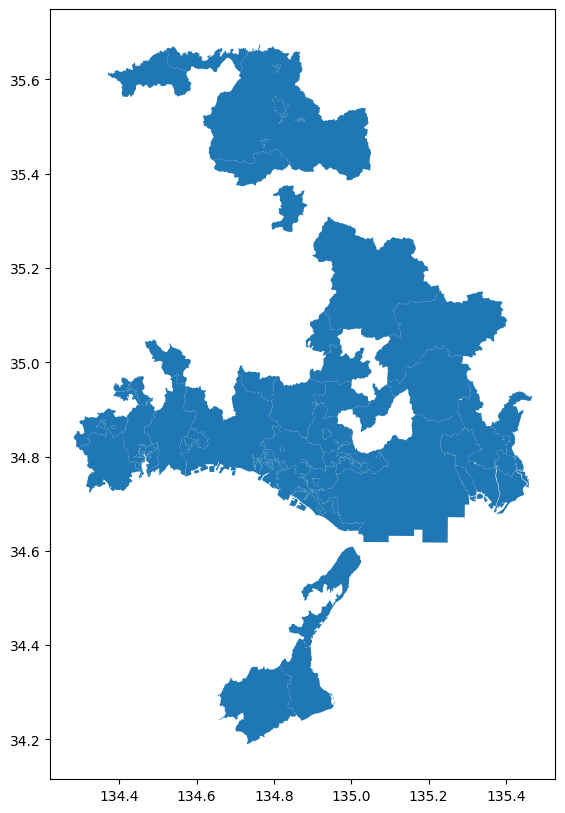

,Type,Pref,Citycode,Cityname
0,都市計画区域,兵庫県,28100,神戸市
1,都市計画区域,兵庫県,28201,姫路市
2,都市計画区域,兵庫県,28201,姫路市
3,都市計画区域,兵庫県,28201,姫路市
4,都市計画区域,兵庫県,28202,尼崎市
...,...,...,...,...
125,都市計画区域,兵庫県,28481,上郡町
126,都市計画区域,兵庫県,28501,佐用町
127,都市計画区域,兵庫県,28501,佐用町
128,都市計画区域,兵庫県,28585,香美町


In [3]:
import geopandas as gpd
import pandas as pd


def merge_shapefiles(file_list: List[str], encoding: str = 'shift-jis') -> gpd.GeoDataFrame:
    gdfs = []
    for file in file_list:
        gdf = gpd.read_file(file, encoding=encoding)
        # 必要な列のみを保持
        gdf = gdf[['Type', 'Pref', 'Citycode', 'Cityname', 'geometry']]
        gdfs.append(gdf)
    
    merged_gdf = pd.concat(gdfs, ignore_index=True)
    return merged_gdf

merged_gdf = merge_shapefiles(file_list)
    
# GeoDataFrameを表示
fig, ax = plt.subplots(figsize=(10, 10))
merged_gdf .plot(ax=ax)
plt.show()

# 属性情報をDataFrameとして取得
attr_df = pd.DataFrame(merged_gdf.drop(columns='geometry'))
display(attr_df)


In [8]:
def split_gdf(gdf):
    # 'Type'の一覧を取得
    list = gdf['Type'].unique()
    
    # GeoDataFrameを分割
    split_gdfs = {i: gdf[gdf['Type'] == i] for i in list}

    return split_gdfs

split_gdfs = split_gdf(merged_gdf)

## kmlへの変換

In [16]:
import os
import geopandas as gpd
import xml.etree.ElementTree as ET
from shapely.geometry import Polygon, MultiPolygon

def reduce_coordinate_precision(coords, precision):
    return [(round(x, precision), round(y, precision)) for x, y in coords]

def simplify_geometry(geom, tolerance):
    if geom.geom_type == 'Polygon':
        return Polygon(geom.exterior.simplify(tolerance))
    elif geom.geom_type == 'MultiPolygon':
        return MultiPolygon([Polygon(p.exterior.simplify(tolerance)) for p in geom.geoms])
    return geom

def create_kml_polygon(coordinates, name, description, style_url):
    placemark = ET.Element('Placemark')
    ET.SubElement(placemark, 'name').text = name
    ET.SubElement(placemark, 'description').text = description
    ET.SubElement(placemark, 'styleUrl').text = style_url
    
    polygon = ET.SubElement(placemark, 'Polygon')
    outer_boundary = ET.SubElement(polygon, 'outerBoundaryIs')
    linear_ring = ET.SubElement(outer_boundary, 'LinearRing')
    coords = ET.SubElement(linear_ring, 'coordinates')
    
    coord_str = ' '.join([f"{x},{y}" for x, y in coordinates])
    coords.text = coord_str
    
    return placemark

def create_style(style_id, color):
    style = ET.Element('Style', id=style_id)
    line_style = ET.SubElement(style, 'LineStyle')
    ET.SubElement(line_style, 'color').text = color
    ET.SubElement(line_style, 'width').text = '2'
    poly_style = ET.SubElement(style, 'PolyStyle')
    ET.SubElement(poly_style, 'fill').text = '0'  # 塗りつぶしなし
    ET.SubElement(poly_style, 'outline').text = '1'  # 輪郭線あり
    return style

def save_kml(split_gdfs, output_dir, coordinate_precision=5, simplify_tolerance=0.00001):
    os.makedirs(output_dir, exist_ok=True)

    style_ids = {
        '都市計画区域': 'style_1low',
    }

    colors = {
        'style_1low': 'ff404040',  # 濃いグレー
    }

    for key, gdf in split_gdfs.items():
        filename = f"{key.replace(' ', '_')}.kml"
        filepath = os.path.join(output_dir, filename)
        
        gdf_wgs84 = gdf.to_crs("EPSG:4326")
        
        kml = ET.Element('kml', xmlns="http://www.opengis.net/kml/2.2")
        document = ET.SubElement(kml, 'Document')
        
        style_id = style_ids.get(key, f'style_{key}')
        color = colors.get(style_id, 'ff404040')  # デフォルト色も濃いグレーに変更
        document.append(create_style(style_id, color))
        
        for _, row in gdf_wgs84.iterrows():
            geom = simplify_geometry(row['geometry'], simplify_tolerance)
            name = str(key)
            description = f"<![CDATA[<h3>{key}</h3><table border='1'><tr><th>属性</th><th>値</th></tr>"
            for col in ['important_attr1', 'important_attr2']:  # Only include important attributes
                if col in gdf_wgs84.columns:
                    description += f"<tr><td>{col}</td><td>{row[col]}</td></tr>"
            description += "</table>]]>"
            
            style_url = f"#{style_id}"
            
            if geom.geom_type == 'Polygon':
                coords = reduce_coordinate_precision(list(geom.exterior.coords), coordinate_precision)
                placemark = create_kml_polygon(coords, name, description, style_url)
                document.append(placemark)
            elif geom.geom_type == 'MultiPolygon':
                for poly in geom.geoms:
                    coords = reduce_coordinate_precision(list(poly.exterior.coords), coordinate_precision)
                    placemark = create_kml_polygon(coords, name, description, style_url)
                    document.append(placemark)
        
        tree = ET.ElementTree(kml)
        tree.write(filepath, encoding='utf-8', xml_declaration=True)
        
        print(f"保存完了: {filepath}")
    
    print(f"\n全てのKMLファイルが {output_dir} に保存されました。")

# 使用例
output_directory = "./kml_output/01_都市計画区域"
save_kml(split_gdfs, output_directory, coordinate_precision=5, simplify_tolerance=0.00001)

保存完了: ./kml_output/01_都市計画区域\都市計画区域.kml

全てのKMLファイルが ./kml_output/01_都市計画区域 に保存されました。
